<a href="https://colab.research.google.com/github/zeljobers/DL-hw1/blob/main/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  https://www.kaggle.com/datasets/mirichoi0218/insurance
# https://colab.research.google.com/drive/1Yzj3s5vLBWPQUk3MO4LZ-Zv5aUZ4u3ak?usp=sharing
# https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb#scrollTo=tsfE4ujDL4ju
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

dataframe = pd.read_csv('./insurance.csv')
dataframe = dataframe.reindex(np.random.permutation(dataframe.index))

test_dataframe = pd.read_csv('./insurance.csv')

df1 = dataframe
df1 = df1.drop_duplicates()
train_df = df1
train_df_regr = df1.copy()

test_dataframe = test_dataframe.drop_duplicates()
test_df = test_dataframe
test_df_regr = df1.copy()

le = LabelEncoder()
encoded_sex = le.fit_transform(df1['sex'])
train_df['sex'] = le.fit_transform(df1['sex'])
test_df['sex'] = le.fit_transform(df1['sex'])

encoded_smoker = le.fit_transform(df1['smoker'])
train_df['smoker'] = le.fit_transform(df1['smoker'])
test_df['smoker'] = le.fit_transform(df1['smoker'])
encoded_region = le.fit_transform(df1['region'])
train_df['region'] = le.fit_transform(df1['region'])
test_df['region'] = le.fit_transform(df1['region'])


In [ ]:
#concatenate samo prima int i string vrednosti
# https://www.tensorflow.org/api_docs/python/tf/dtypes
# https://www.tensorflow.org/guide/keras/preprocessing_layers
inputs = {
    'sex': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='sex'),
    'smoker': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='smoker'),
    'region': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='region'),
    'age': tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='age'),
    'bmi':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='bmi'),
    'children':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='children')
}


encoded_sex_norm = tf.keras.layers.Normalization(name='normalization_encoded_sex', axis=None)
encoded_sex_norm.adapt(encoded_sex.reshape(-1, 1))
encoded_sex_norm = encoded_sex_norm(inputs.get('sex'))

encoded_smoker_norm = tf.keras.layers.Normalization(name='normalization_encoded_smoker', axis=None)
encoded_smoker_norm.adapt(encoded_smoker.reshape(-1, 1))
encoded_smoker_norm = encoded_smoker_norm(inputs.get('smoker'))

encoded_region_norm = tf.keras.layers.Normalization(name='normalization_encoded_region', axis=None)
encoded_region_norm.adapt(encoded_region.reshape(-1, 1))
encoded_region_norm = encoded_region_norm(inputs.get('region'))

encoded_sex_norm = tf.keras.layers.Discretization(
    name='discretization_encoded_sex')(encoded_sex_norm)

encoded_smoker_norm = tf.keras.layers.Discretization(
    name='discretization_encoded_smoker')(encoded_smoker_norm)


encoded_region_norm = tf.keras.layers.Discretization(
    name='discretization_encoded_region')(encoded_region_norm)


age = tf.keras.layers.Normalization(
    name='normalization_age',
    axis=None
    # output_mode='one_hot'
    )
age.adapt(df1['age'].to_numpy().reshape(-1,1))
age = age(inputs.get('age'))


age = tf.keras.layers.Discretization(
    name='discretization_age'
    )(age)

bmi = tf.keras.layers.Normalization(
    name='normalization_bmi',
    axis=None
    )
bmi.adapt(df1['bmi'].to_numpy().reshape(-1,1))
bmi = bmi(inputs.get('bmi'))

bmi = tf.keras.layers.Discretization(
    name='discretization_bmi'
    )(bmi)

children = tf.keras.layers.Normalization(
    name='normalization_children',
    axis=None
    # output_mode='one_hot'
    )
children.adapt(df1['children'].to_numpy().reshape(-1,1))
children = children(inputs.get('children'))


children = tf.keras.layers.Discretization(
    name='discretization_children'
    )(children)


feature_cross1 = tf.keras.layers.HashedCrossing(
    num_bins=len(np.unique(df1['sex'])) * len(np.unique(df1['smoker'])),
    output_mode='int',
    name='cross_1')([encoded_sex_norm, encoded_smoker_norm])



preprocessing_layers = tf.keras.layers.Concatenate()(
  [age, encoded_region_norm, feature_cross1, bmi, children])



In [ ]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [ ]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_charges_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [ ]:
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_charges_normalized = tf.keras.layers.Normalization(axis=None)
train_charges_normalized.adapt(
    np.array(train_df['charges']))

test_charges_normalized = tf.keras.layers.Normalization(axis=None)
test_charges_normalized.adapt(
    np.array(test_df['charges']))

In [ ]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

Epoch 1/15
2/2 [==============================] - 1s 267ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 1.0172 - val_mean_squared_error: 1.0172
Epoch 2/15
2/2 [==============================] - 0s 45ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 1.0184 - val_mean_squared_error: 1.0184
Epoch 3/15
2/2 [==============================] - 0s 39ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 1.0187 - val_mean_squared_error: 1.0187
Epoch 4/15
2/2 [==============================] - 0s 67ms/step - loss: 0.9963 - mean_squared_error: 0.9963 - val_loss: 1.0184 - val_mean_squared_error: 1.0184
Epoch 5/15
2/2 [==============================] - 0s 55ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 1.0178 - val_mean_squared_error: 1.0178
Epoch 6/15
2/2 [==============================] - 0s 56ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 1.0170 - val_mean_squared_error: 1.0170
Epoch 7/15
2/2 [=============================

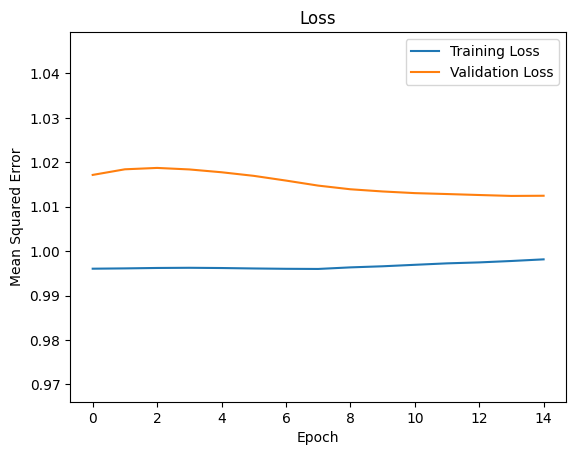


 Evaluate the linear regression model against the test set:
2/2 [==============================] - 0s 9ms/step - loss: 1.0009 - mean_squared_error: 1.0009


{'loss': 1.0009459257125854, 'mean_squared_error': 1.0009459257125854}

In [ ]:
 # The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "charges"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_charges_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [ ]:
#@title DNN
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

Epoch 1/20
2/2 [==============================] - 1s 438ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 1.0146 - val_mean_squared_error: 1.0146
Epoch 2/20
2/2 [==============================] - 0s 57ms/step - loss: 0.9963 - mean_squared_error: 0.9963 - val_loss: 1.0161 - val_mean_squared_error: 1.0161
Epoch 3/20
2/2 [==============================] - 0s 59ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 1.0172 - val_mean_squared_error: 1.0172
Epoch 4/20
2/2 [==============================] - 0s 72ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 1.0175 - val_mean_squared_error: 1.0175
Epoch 5/20
2/2 [==============================] - 0s 56ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 1.0176 - val_mean_squared_error: 1.0176
Epoch 6/20
2/2 [==============================] - 0s 78ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 1.0176 - val_mean_squared_error: 1.0176
Epoch 7/20
2/2 [=============================

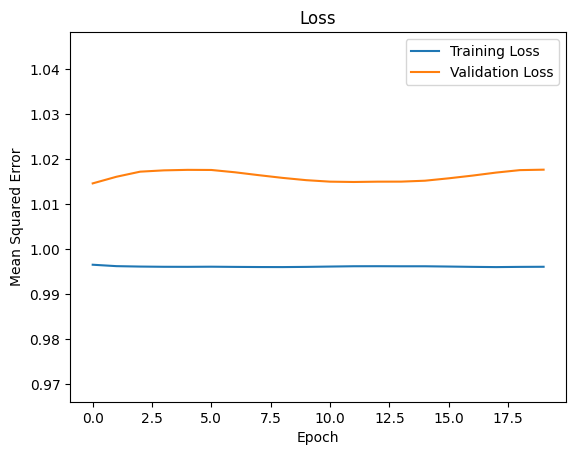


 Evaluate the new model against the test set:
2/2 [==============================] - 0s 8ms/step - loss: 1.0004 - mean_squared_error: 1.0004


{'loss': 1.0004442930221558, 'mean_squared_error': 1.0004442930221558}

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "charges"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_charges_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

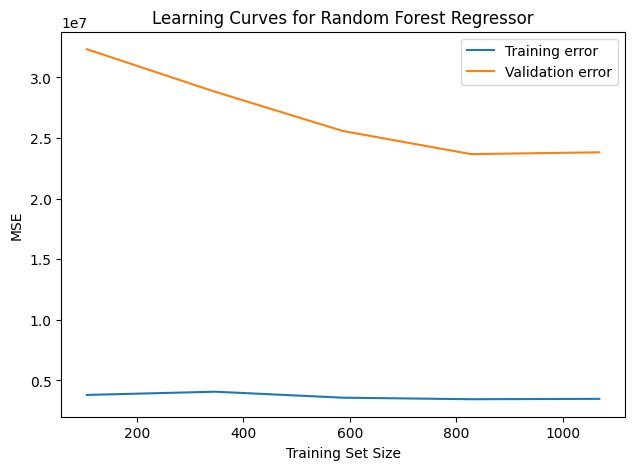

In [ ]:
# @title Task 1, but it is RandomForestRegressor instead of baseline LinearRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

X_train = train_df.iloc[:, :-1]
X_test = test_df.iloc[:, :-1]
Y_train = train_df.iloc[:, -1]
Y_test = test_df.iloc[:, -1]

# default n_estimator = 100
model = RandomForestRegressor()
train_sizes, train_scores, validation_scores = learning_curve(
    model, X_train, Y_train,
    scoring='neg_mean_squared_error')

# Calculate the mean for training set scores
train_scores_mean = -train_scores.mean(axis=1)

# Calculate the mean for validation set scores
validation_scores_mean = -validation_scores.mean(axis=1)

# Plot the learning curve
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, validation_scores_mean, label='Validation error')
plt.title('Learning Curves for Random Forest Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.legend(loc="best")
plt.show()

In [ ]:
# @title Task 2 bro with everything already set;
# trying out Multilayered (2 hidden layers) perceptron with 10, 6 nodes in hidden layer, 1 node in output.
# input layer was set beforehand;
# overfitting was considered to be performed over 1st layer in DNN.
def get_outputs_dnn():
  # Create a Dense layer with 10 nodes.
  dense_output = tf.keras.layers.Dense(units=10,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Dropout for sake of avoiding overfitting, where some of the neurons/nodes got turned off
  dense_output = tf.keras.layers.Dropout(0.2) (dense_output)
  # Create a Dense layer with 6 nodes.
  dense_output = tf.keras.layers.Dense(units=6,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

Epoch 1/20
2/2 [==============================] - 1s 315ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 1.0173 - val_mean_squared_error: 1.0173
Epoch 2/20
2/2 [==============================] - 0s 39ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 1.0180 - val_mean_squared_error: 1.0180
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.9961 - mean_squared_error: 0.9961 - val_loss: 1.0169 - val_mean_squared_error: 1.0169
Epoch 4/20
2/2 [==============================] - 0s 59ms/step - loss: 0.9960 - mean_squared_error: 0.9960 - val_loss: 1.0156 - val_mean_squared_error: 1.0156
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 1.0148 - val_mean_squared_error: 1.0148
Epoch 6/20
2/2 [==============================] - 0s 44ms/step - loss: 0.9963 - mean_squared_error: 0.9963 - val_loss: 1.0146 - val_mean_squared_error: 1.0146
Epoch 7/20
2/2 [=============================

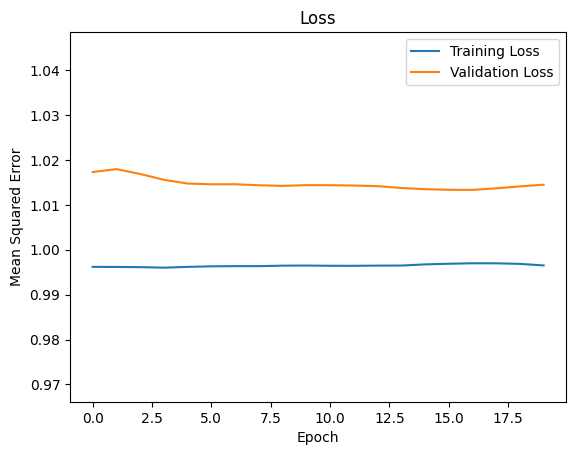

2/2 [==============================] - 0s 8ms/step - loss: 1.0000 - mean_squared_error: 1.0000


{'loss': 1.0000150203704834, 'mean_squared_error': 1.0000150203704834}

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "charges"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_charges_normalized(np.array(test_features.pop(label_name))) # isolate the label
# print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)